<a href="https://colab.research.google.com/github/Hussien-Sayed/Earthquake-Modelling/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Load the data

In [ ]:
!pip install contextily

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.preprocessing import MinMaxScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Default Experiment config
n_clusters = 60

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EM/updated_minable_SEOD.csv")

## Cluster The Data

In [ ]:
def calculate_clustering(df,n_clusters=60, normalized=False,):
    """
    Function to calculate clustering of the dataframe based on latitude and longitude
    Args:
        df: Dataframe
        normalized: (Boolean). Whether to normalized data or not before the clustering.

    Returns:Dataframe with cluster_label as new column.

    """
    df.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
    coords = df[['latitude', 'longitude']]
    if normalized:
        scaler = MinMaxScaler()
        coords = scaler.fit_transform(coords)
    kmeans = KMeans(n_clusters =n_clusters , init ='k-means++')
    kmeans.fit(coords) # Compute k-means clustering.
    df['cluster_label'] = kmeans.fit_predict(coords)
    labels = kmeans.predict(coords) # Labels of each point
    centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
    return df

In [ ]:
df = calculate_clustering(df,n_clusters=n_clusters, normalized=False)

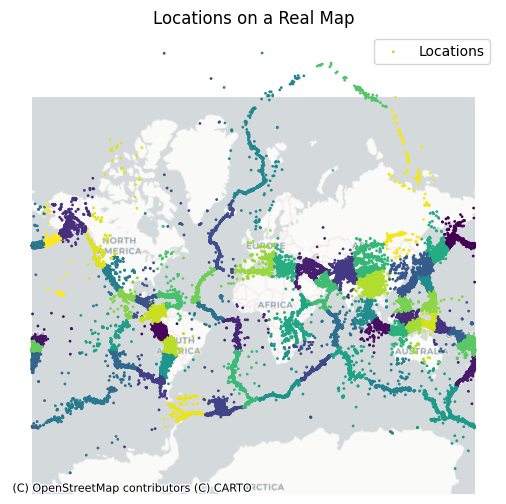

In [ ]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip") #"https://data.buffalony.gov/resource/d6g9-xbgu.geojson"

gdf = gpd.sjoin(gdf, world, how="left", predicate="within")

gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax,column='cluster_label', cmap='viridis', markersize=1, label="Locations")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  # You can change the basemap provider
ax.set_title("Locations on a Real Map")
ax.legend()
ax.set_axis_off()
plt.show()


## Complete the Data

In [ ]:
#define day_frac
time_value = pd.to_datetime(df.time.apply(lambda x:x.split()[1]).apply(lambda x:x.split("+")[0]))
df["day_frac"] = (time_value.dt.hour * 3600 + time_value.dt.minute * 60 + time_value.dt.second)/ (24 * 60 * 60)


<ipython-input-9-2f802f072179>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_value = pd.to_datetime(df.time.apply(lambda x:x.split()[1]).apply(lambda x:x.split("+")[0]))


In [ ]:
# define a row for all clusters for all days
filled_data = df[['year','month','day']].copy()
filled_data.drop_duplicates(inplace=True)
filled_data_clusters = filled_data.loc[filled_data.index.repeat(n_clusters)].reset_index(drop=True)
filled_data_clusters["cluster_label"] = np.tile(np.arange(n_clusters), len(filled_data)).astype("int32")

#define cols to be merged with the filled_data_clusters
non_cluster_cols = df.columns.difference(['latitude', 'longitude', 'depth', 'mag','cluster_label',"time","day_frac"])

#,'ill_frac_interpolated','r/km_interpolated', 'dec_interpolated','ra/h_interpolated',
#'ra/°_interpolated', 'td_acc_interpolated',

#define cols to be aggregated
cluster_cols = df.columns.difference(non_cluster_cols).tolist() + ['year','month','day']
cluster_cols.remove("time")

filled_data_clusters = filled_data_clusters.merge(df[non_cluster_cols].drop_duplicates(),how ="left",on=['year','month','day'])
n_earthquakes = df[cluster_cols].groupby(['year','month','day','cluster_label']).day.count().rename("n_earthquakes")
agg_df_per_cluster = df[cluster_cols].groupby(['year','month','day','cluster_label']).mean()
agg_df_per_cluster = pd.concat((agg_df_per_cluster,n_earthquakes),axis=1).reset_index()
filled_data_clusters = filled_data_clusters.merge(agg_df_per_cluster,how ="left",on=['year','month','day','cluster_label'])

filled_data_clusters["mag"] = filled_data_clusters["mag"].fillna(0)
filled_data_clusters["n_earthquakes"] = filled_data_clusters["n_earthquakes"].fillna(0)
nan_cols = filled_data_clusters.columns[filled_data_clusters.isna().any(axis=0)]

filled_data_clusters[nan_cols] = filled_data_clusters[nan_cols].fillna(filled_data_clusters.groupby(['year','month','day'])[nan_cols].transform('mean'))

# inverse clusters to sample locations for generated data of non-existing Earthquakes
for cluster_ix in tqdm(filled_data_clusters.cluster_label.unique()):
    df_to_fill_ix = (filled_data_clusters["cluster_label"] == cluster_ix)&(filled_data_clusters["n_earthquakes"] == 0)
    df_from_fill_ix = (filled_data_clusters["cluster_label"] == cluster_ix)&(filled_data_clusters["n_earthquakes"] != 0)
    n_samples = sum(df_to_fill_ix)
    filled_data_clusters.loc[df_to_fill_ix, ["latitude","longitude"] ] = \
    filled_data_clusters.loc[df_from_fill_ix, ["latitude","longitude"] ].sample(n_samples,replace=True).values

#define random values for day_frac of non-existing Earthquakes
filled_data_clusters.loc[filled_data_clusters.mag==0,"day_frac"] = np.random.rand((filled_data_clusters.mag==0).sum())

#define intrp values
delta = filled_data_clusters[['ill_frac_1','r/km_1','dec_1','ra/h_1','ra/°_1','td_acc_1']].values - filled_data_clusters[['ill_frac','r/km','dec','ra/h','ra/°','td_acc']].values
filled_data_clusters[['ill_frac_interpolated','r/km_interpolated','dec_interpolated','ra/h_interpolated','ra/°_interpolated','td_acc_interpolated']] = filled_data_clusters[['ill_frac','r/km','dec','ra/h','ra/°','td_acc']].values + delta * filled_data_clusters.day_frac.values.reshape(-1,1)


#remove range(4.5-4.8) from being considered as earthquake
filled_data_clusters.loc[filled_data_clusters.mag<4.8,"n_earthquakes"] = 0
filled_data_clusters.loc[filled_data_clusters.mag<4.8,"mag"] = 0

#fill 0 values eathquake magnitude with a distribution for un noticed earthquake magnitudes
#ix1 = np.arange(0,1.7,0.00671)
#ix2 = np.arange(1.7,4.5,0.00671)

#val1 = [3.5]*len(ix1)
#val2 = np.linspace(3.5,1,len(ix2))
#ix = np.hstack((ix1,ix2))
#val = np.hstack((val1,val2))
#val = np.power(10,val)

#gen_dist = []
#for i,v in zip(ix,val):
#    gen_dist.extend([i]*int(v))
#np.random.shuffle(gen_dist)

#filled_data_clusters.loc[filled_data_clusters.mag==0,"mag"] = gen_dist[:(filled_data_clusters.mag==0).sum()]
filled_data_clusters.loc[filled_data_clusters.mag==0,"mag"] = 2.4  #median value


#add date
tot_sec = filled_data_clusters["day_frac"] * 24 * 60 * 60
#filled_data_clusters["hour"] = tot_sec//(60*60)
#filled_data_clusters["minute"] = tot_sec%(60*60)//60
#filled_data_clusters["second"] = tot_sec%60
#filled_data_clusters['date'] = pd.to_datetime(filled_data_clusters[['year', 'month', 'day','hour','minute','second']])
filled_data_clusters['date'] = pd.to_datetime(filled_data_clusters[['year', 'month', 'day']])

filled_data_clusters = filled_data_clusters.pivot(columns="cluster_label",index="date",values="mag").reset_index()

100%|██████████| 60/60 [00:06<00:00,  9.28it/s]


In [ ]:
filled_data_clusters.to_csv("Eq_time_data.csv",index=None)

## Clone IT repo

In [ ]:
!pip install reformer_pytorch

In [ ]:
!git clone https://github.com/thuml/iTransformer.git

Cloning into 'iTransformer'...
remote: Enumerating objects: 778, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 778 (delta 315), reused 290 (delta 290), pack-reused 438 (from 2)
Receiving objects: 100% (778/778), 11.76 MiB | 7.37 MiB/s, done.
Resolving deltas: 100% (483/483), done.


## Modify data_loader.py file

Before you go on with training you need to modify the following script "data_loader.py" with the cell content provided under this section

/content/iTransformer/data_provider/data_loader.py


In [ ]:

import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from utils.timefeatures import time_features
import warnings

warnings.filterwarnings('ignore')


class Dataset_ETT_hour(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_ETT_minute(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTm1.csv',
                 target='OT', scale=True, timeenc=0, freq='t'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 * 4 - self.seq_len, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - self.seq_len]
        border2s = [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 8 * 30 * 24 * 4]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_Custom(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        cols = list(df_raw.columns)
        #cols.remove(self.target)
        cols.remove('date')
        df_raw = df_raw[['date'] + cols ] #+ [self.target]
        num_train = int(len(df_raw) * 0.7)
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_PEMS(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h'):
        # size [seq_len, label_len, pred_len]
        # info
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        data_file = os.path.join(self.root_path, self.data_path)
        data = np.load(data_file, allow_pickle=True)
        data = data['data'][:, :, 0]

        train_ratio = 0.6
        valid_ratio = 0.2
        train_data = data[:int(train_ratio * len(data))]
        valid_data = data[int(train_ratio * len(data)): int((train_ratio + valid_ratio) * len(data))]
        test_data = data[int((train_ratio + valid_ratio) * len(data)):]
        total_data = [train_data, valid_data, test_data]
        data = total_data[self.set_type]

        if self.scale:
            self.scaler.fit(train_data)
            data = self.scaler.transform(data)

        df = pd.DataFrame(data)
        df = df.fillna(method='ffill', limit=len(df)).fillna(method='bfill', limit=len(df)).values

        self.data_x = df
        self.data_y = df

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = torch.zeros((seq_x.shape[0], 1))
        seq_y_mark = torch.zeros((seq_x.shape[0], 1))

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_Solar(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h'):
        # size [seq_len, label_len, pred_len]
        # info
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = []
        with open(os.path.join(self.root_path, self.data_path), "r", encoding='utf-8') as f:
            for line in f.readlines():
                line = line.strip('\n').split(',')
                data_line = np.stack([float(i) for i in line])
                df_raw.append(data_line)
        df_raw = np.stack(df_raw, 0)
        df_raw = pd.DataFrame(df_raw)

        num_train = int(len(df_raw) * 0.7)
        num_test = int(len(df_raw) * 0.2)
        num_valid = int(len(df_raw) * 0.1)
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_valid, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        df_data = df_raw.values

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data)
            data = self.scaler.transform(df_data)
        else:
            data = df_data

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = torch.zeros((seq_x.shape[0], 1))
        seq_y_mark = torch.zeros((seq_x.shape[0], 1))

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_Pred(Dataset):
    def __init__(self, root_path, flag='pred', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, inverse=False, timeenc=0, freq='15min', cols=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['pred']

        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        self.cols = cols
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        if self.cols:
            cols = self.cols.copy()
            cols.remove(self.target)
        else:
            cols = list(df_raw.columns)
            cols.remove(self.target)
            cols.remove('date')
        df_raw = df_raw[['date'] + cols + [self.target]]
        border1 = len(df_raw) - self.seq_len
        border2 = len(df_raw)

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len + 1, freq=self.freq)

        df_stamp = pd.DataFrame(columns=['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = self.data_x[r_begin:r_begin + self.label_len]
        else:
            seq_y = self.data_y[r_begin:r_begin + self.label_len]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


## Start Training

In [ ]:
%cd /content/iTransformer
!python -u run.py \
  --is_training 1 \
  --root_path ../ \
  --data_path Eq_time_data.csv \
  --model_id Eq_time_data \
  --model iTransformer \
  --data custom \
  --features M \
  --seq_len 96 \
  --pred_len 96 \
  --e_layers 4 \
  --enc_in 862 \
  --dec_in 862 \
  --c_out 862 \
  --des 'Exp' \
  --d_model 512\
  --d_ff 512 \
  --batch_size 16 \
  --learning_rate 0.001 \
  --itr 1 \



/content/iTransformer
Args in experiment:
Namespace(is_training=1, model_id='Eq_time_data', model='iTransformer', data='custom', root_path='../', data_path='Eq_time_data.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=1, enc_in=862, dec_in=862, c_out=862, d_model=256, n_heads=8, e_layers=1, d_layers=1, d_ff=256, moving_avg=25, factor=1, distil=True, dropout=0.1, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=1, train_epochs=10, batch_size=16, patience=3, learning_rate=0.001, des='Exp', loss='MAE', lradj='type1', use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', exp_name='MTSF', channel_independence=False, inverse=False, class_strategy='projection', target_root_path='./data/electricity/', target_data_path='electricity.csv', efficient_training=False, use_norm=True, partial_start_index=0)
Use GPU: cuda:0
>>>>>>>start training : Eq_time_data_iTransformer_cu